# Colorize Points

In [1]:
#%matplotlib widget
import os
import numpy as np
import pandas as pd

from PIL import Image
from joblib import dump, load

from sklearn.neighbors import KNeighborsClassifier

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from bring_features_and_file_paths import bring_features_and_file_paths, transform_features
from bring_features_and_file_paths import from_spectrogram_path_to_BirdNET_output_path
from bring_features_and_file_paths import get_spectrogram_time_mark_in_file
from bring_features_and_file_paths import get_BirdNET_detections

First bring the features and the file names

In [2]:
features, file_paths, _ = bring_features_and_file_paths('/grand/projects/BirdAudio/Soundscapes/Features', 0.99)

We have 100065 feature vectors.


Now, we want to transform the features, scaling them and reducing their dimensionality

In [3]:
dim_red_model = load('/grand/projects/BirdAudio/Soundscapes/Clusters/ThirdClusters/dim_red_model')
scale_model = load('/grand/projects/BirdAudio/Soundscapes/Clusters/ThirdClusters/scale_model')

In [4]:
samples = transform_features(features, scale_model, dim_red_model)
samples.shape
X=samples
n_components=X.shape[1]

Load the clusters generated from the features

We will use them to classify our sample of features now

In [5]:
clusters = np.load('/grand/projects/BirdAudio/Soundscapes/Clusters/ThirdClusters/clusters.npy', allow_pickle=True)
vectors=clusters[()]['x']
labels=clusters[()]['y']

aux_labels = labels

In [6]:
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)
print("Estimated number of clusters: %d" % n_clusters_)
print("Estimated number of noise points: %d" % n_noise_)

Estimated number of clusters: 100
Estimated number of noise points: 0


Train a k-nearest neighbor algorithm to predict the samples

In [7]:
neigh = KNeighborsClassifier(n_neighbors=10)
neigh.fit(vectors, labels)

KNeighborsClassifier(n_neighbors=10)

Classify the samples

In [8]:
noise=-1
label_predictions=neigh.predict(X)
core_samples_mask = np.zeros_like(label_predictions, dtype=bool)
core_samples_mask[label_predictions != noise] = True
n_noise_points = list(label_predictions).count(noise)
#set(label_predictions)

Plot them

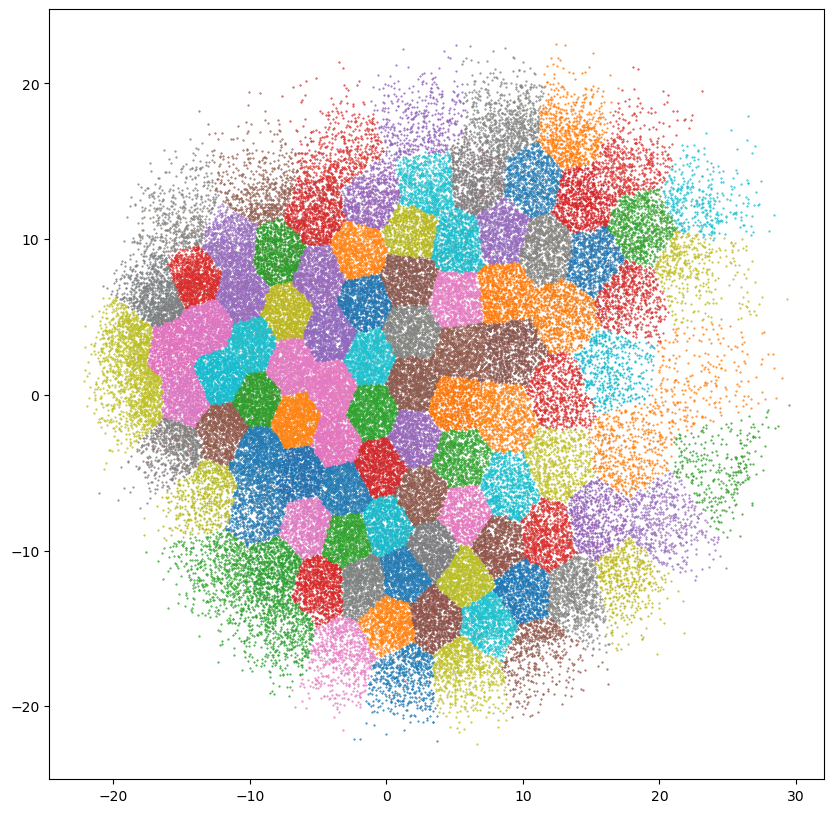

Estimated number of clusters: 100.
Estimated number of noise points during training: 0.
Number of noise points during inference: 0.



In [14]:
# Black removed and is used for noise instead.
print_outliers=False
unique_labels = set(labels)
colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]
if n_components == 2:
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111)
    for k, col in zip(unique_labels, colors):
        if k == noise:
            # Black used for noise.
            col = [0, 0, 0, 1]

        class_member_mask = label_predictions == k
        #class_member_mask = labels == k
        xy = X[class_member_mask & core_samples_mask]
        ax.plot(
            xy[:, 0],
            xy[:, 1],
            "o",
            markerfacecolor=tuple(col),
            #markeredgecolor="k",
            markersize=0.5,
        )

        if print_outliers:
            xy = X[class_member_mask & ~core_samples_mask]
            ax.plot(
                xy[:, 0],
                xy[:, 1],
                "o",
                markerfacecolor=tuple(col),
                #markeredgecolor="k",
                markersize=0.6,
            )
    

elif n_components == 3:
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111, projection='3d')
    for k, col in zip(unique_labels, colors):
        if k == noise:
            # Black used for noise.
            col = [0, 0, 0, 1]

        class_member_mask = label_predictions == k
        #class_member_mask = labels == k
        xyz = X[class_member_mask & core_samples_mask]
        ax.scatter(
            xyz[:, 0],
            xyz[:, 1],
            xyz[:, 2],
            "o",
            c=[col],
            s=2,
        )

        if print_outliers:
            xyz = X[class_member_mask & ~core_samples_mask]
            ax.scatter(
                xyz[:, 0],
                xyz[:, 1],
                xyz[:, 2],
                "o",
                c=[col],
                s=1,
            )
    

string0 = "Estimated number of clusters: {}.\n"
string1 = "Estimated number of noise points during training: {}.\n"
string2 = "Number of noise points during inference: {}.\n"
string = string0 + string1 + string2
#plt.title(string .format(n_clusters_, n_noise_, n_noise_points))

plt.show()

print(string .format(n_clusters_, n_noise_, n_noise_points))

In [15]:
BirdNET_BASE_PATH = '/grand/projects/BirdAudio/Soundscapes/BirdNET_Output'
Spectrograms_BASE_PATH = '/grand/projects/BirdAudio/Soundscapes/Second_Filtered_Spectrograms'
spectrogram_duration = 9.0
data = []
expulse = []
for k, fpath in enumerate(file_paths):
    file_path = ''.join([chr(int(x)) for x in fpath]).replace('~','')
    BirdNET_PATH = from_spectrogram_path_to_BirdNET_output_path(fpath)
    try:
        start_time = get_spectrogram_time_mark_in_file(fpath, spectrogram_duration)
        interval = (start_time, start_time + spectrogram_duration)
        data_elements = get_BirdNET_detections(os.path.join(BirdNET_BASE_PATH, BirdNET_PATH), interval, confidence_threshold = 0.30)
        confidence=-1.0
        for data_element in data_elements:
            if data_element['confidence'] > confidence:
                confidence=data_element['confidence']
                element=data_element

        data.append(element)
    except:
        print("Something was wrong with")
        print(file_path)
        expulse.append(k)
    
data = pd.DataFrame(data=data)
expulse = np.array(expulse)


if len(expulse) > 0:
    X = np.delete(X, expulse, 0)
    label_predictions = np.delete(label_predictions, expulse, 0)
    
data['labels']=label_predictions

Something was wrong with
                                                                                 
Something was wrong with
                                                                                 
Something was wrong with
                                                                                 
Something was wrong with
                                                                                 
Something was wrong with
                                                                                 
Something was wrong with
                                                                                 
Something was wrong with
                                                                                 
Something was wrong with
                                                                                 


In [16]:
for element in data:
    print(element)

detection
confidence
year
month
day
hour
minute
second
week
weekday
device
set
labels


In [17]:
def numerate_array(array):
    output=[]
    unique=np.unique(array)
    for element in array:
        output.append(np.where(unique==element)[0].item())
        
    return np.array(output)

In [33]:
AUX=numerate_array(np.array(data['month']))

In [34]:
#noise=-1
#noise=np.where(np.unique(data['detection'])=='No detection')[0].item()
#noise=np.where(np.unique(data['weekday'])==7)[0].item()

label_predictions=AUX
labels=AUX
core_samples_mask = np.zeros_like(label_predictions, dtype=bool)
core_samples_mask[label_predictions != noise] = True
n_noise_points = list(label_predictions).count(noise)

n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)

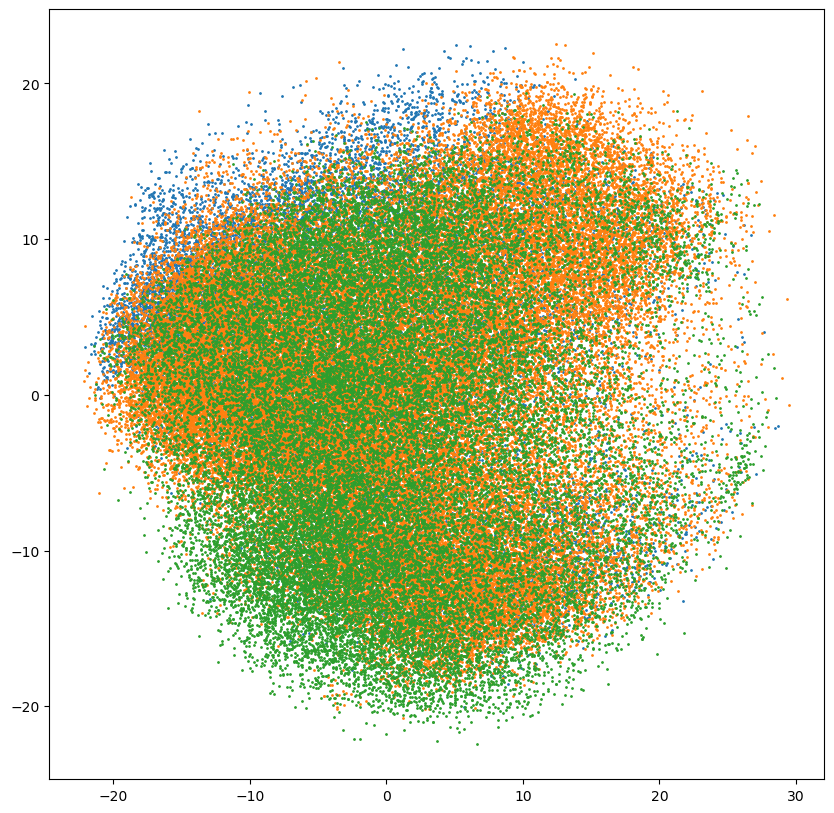

Estimated number of clusters: 3.
Estimated number of noise points during training: 0.
Number of noise points during inference: 0.



In [35]:
# Black removed and is used for noise instead.
print_outliers=False
unique_labels = set(labels)
colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]
if n_components == 2:
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111)
    for k, col in zip(unique_labels, colors):
        if k == noise:
            # Black used for noise.
            col = [0, 0, 0, 1]

        class_member_mask = label_predictions == k
        #class_member_mask = labels == k
        xy = X[class_member_mask & core_samples_mask]
        ax.plot(
            xy[:, 0],
            xy[:, 1],
            "o",
            markerfacecolor=tuple(col),
            #markeredgecolor="k",
            markersize=1,
        )

        if print_outliers:
            xy = X[class_member_mask & ~core_samples_mask]
            ax.plot(
                xy[:, 0],
                xy[:, 1],
                "o",
                markerfacecolor=tuple(col),
                #markeredgecolor="k",
                markersize=0.6,
            )
    

elif n_components == 3:
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111, projection='3d')
    for k, col in zip(unique_labels, colors):
        if k == noise:
            # Black used for noise.
            col = [0, 0, 0, 1]

        class_member_mask = label_predictions == k
        #class_member_mask = labels == k
        xyz = X[class_member_mask & core_samples_mask]
        ax.scatter(
            xyz[:, 0],
            xyz[:, 1],
            xyz[:, 2],
            "o",
            c=[col],
            s=200,
        )

        if print_outliers:
            xyz = X[class_member_mask & ~core_samples_mask]
            ax.scatter(
                xyz[:, 0],
                xyz[:, 1],
                xyz[:, 2],
                "o",
                c=[col],
                s=100,
            )
    

string0 = "Estimated number of clusters: {}.\n"
string1 = "Estimated number of noise points during training: {}.\n"
string2 = "Number of noise points during inference: {}.\n"
string = string0 + string1 + string2
#plt.title(string .format(n_clusters_, n_noise_, n_noise_points))

plt.show()

print(string .format(n_clusters_, n_noise_, n_noise_points))

<AxesSubplot: >

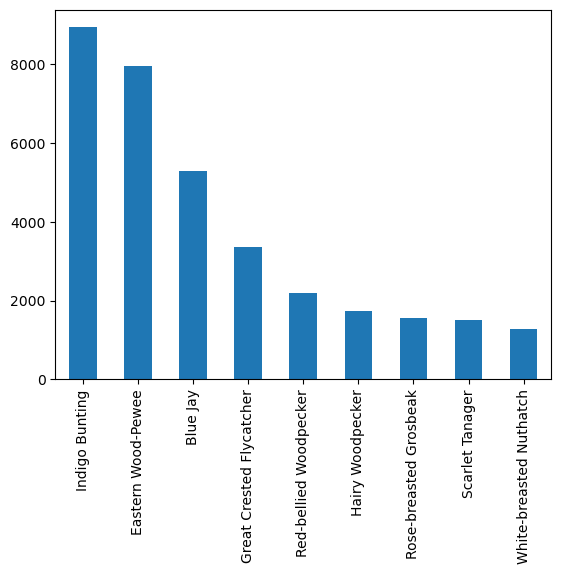

In [23]:
data[data['confidence'] > 0.0].detection.value_counts()[1:10].plot.bar()

In [24]:
np.where(np.unique(data['detection'])=='No detection')[0].item()

40

array([[<AxesSubplot: title={'center': 'week'}>]], dtype=object)

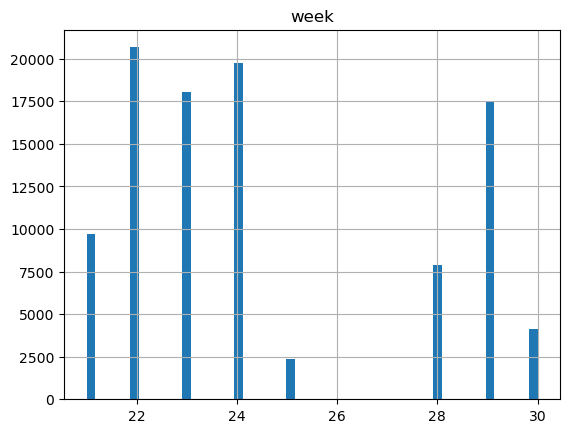

In [25]:
data.hist(column='week', bins=52)

array([[<AxesSubplot: title={'center': 'month'}>]], dtype=object)

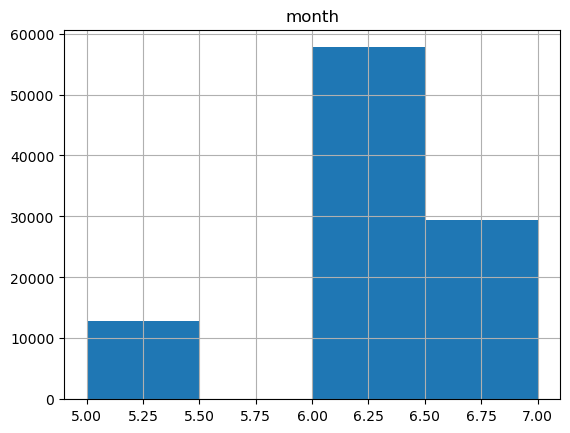

In [26]:
data.hist(column='month', bins=4)

<AxesSubplot: >

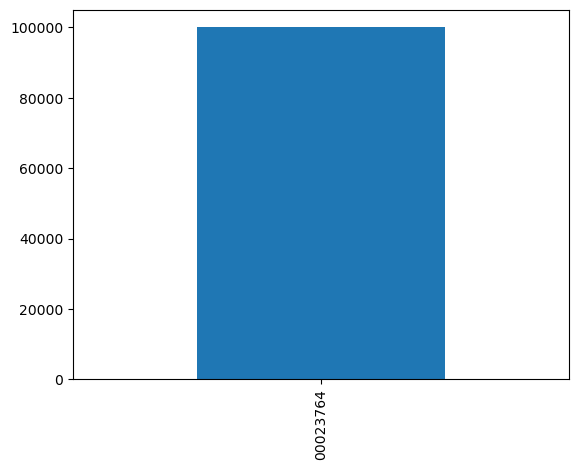

In [27]:
data.device.value_counts().plot.bar()

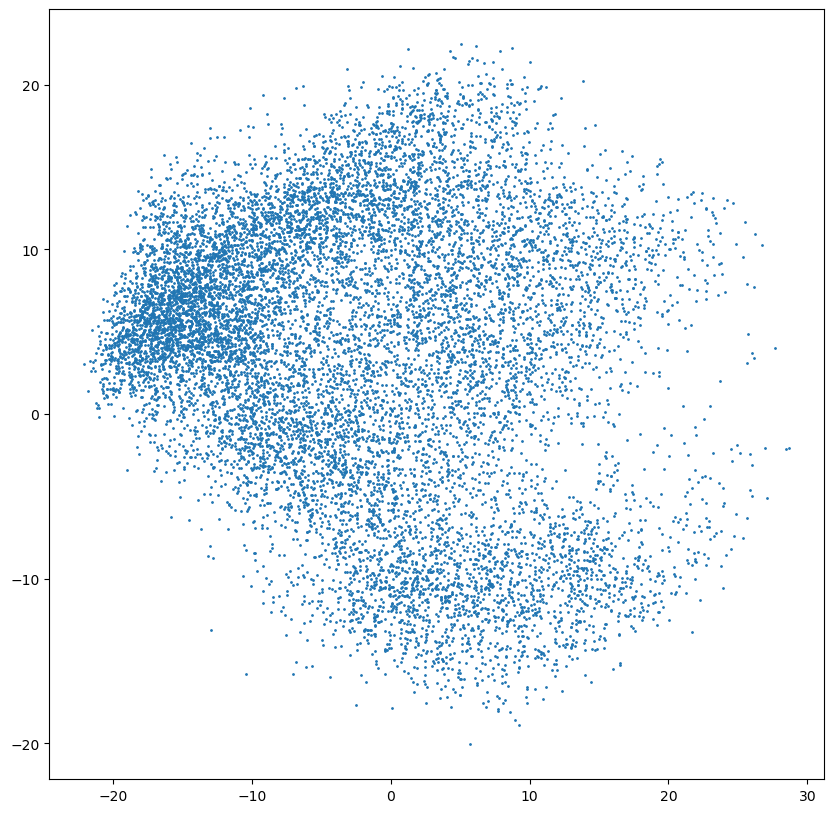

Estimated number of clusters: 3.
Estimated number of noise points during training: 0.
Number of noise points during inference: 0.



In [39]:
# Black removed and is used for noise instead.
label_to_plot=np.where(np.unique(data['month'])==5)[0].item()
print_outliers=False
unique_labels = set(labels)
colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]
if n_components == 2:
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111)
    for k, col in zip(unique_labels, colors):
        if k == noise:
            # Black used for noise.
            col = [0, 0, 0, 1]

        class_member_mask = label_predictions == k
        #class_member_mask = labels == k
        xy = X[class_member_mask & core_samples_mask]
        if k==label_to_plot:
            ax.plot(
                xy[:, 0],
                xy[:, 1],
                "o",
                markerfacecolor=tuple(col),
                #markeredgecolor="k",
                markersize=1,
            )

        if print_outliers:
            xy = X[class_member_mask & ~core_samples_mask]
            ax.plot(
                xy[:, 0],
                xy[:, 1],
                "o",
                markerfacecolor=tuple(col),
                #markeredgecolor="k",
                markersize=0.6,
            )
            
        #plt.xlim([-2*15, 2*20])
        #plt.ylim([-2*15, 2*20])
    

elif n_components == 3:
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111, projection='3d')
    for k, col in zip(unique_labels, colors):
        if k == noise:
            # Black used for noise.
            col = [0, 0, 0, 1]

        class_member_mask = label_predictions == k
        #class_member_mask = labels == k
        xyz = X[class_member_mask & core_samples_mask]
        ax.scatter(
            xyz[:, 0],
            xyz[:, 1],
            xyz[:, 2],
            "o",
            c=[col],
            s=200,
        )

        if print_outliers:
            xyz = X[class_member_mask & ~core_samples_mask]
            ax.scatter(
                xyz[:, 0],
                xyz[:, 1],
                xyz[:, 2],
                "o",
                c=[col],
                s=100,
            )
    

string0 = "Estimated number of clusters: {}.\n"
string1 = "Estimated number of noise points during training: {}.\n"
string2 = "Number of noise points during inference: {}.\n"
string = string0 + string1 + string2
#plt.title(string .format(n_clusters_, n_noise_, n_noise_points))

plt.show()

print(string .format(n_clusters_, n_noise_, n_noise_points))

In [38]:
np.unique(data['month'])

array([5, 6, 7])

In [ ]:
label_predictions.shape

In [ ]:
data['week'].shape

In [ ]:
file_paths.shape[0]

In [ ]:
element

In [ ]:
data.to_csv('/grand/projects/BirdAudio/Soundscapes/Correlated_Data.csv')

In [ ]:
np.any(data['confidence']<0.95)